# Study of Reinforcement Learning based on the [course](https://www.udemy.com/course/practical-ai-with-python-and-reinforcement-learning)

## Libraries
- [Gymnasium](https://gymnasium.farama.org/)

## Deep Q-Learning (DQN) with manual implementation

In [ ]:
!pip install gymnasium[classic-control] matplotlib numpy tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
model_path = "/content/drive/MyDrive/some-path/cart_pole_{best_so_far}.h5"

In [ ]:
if not model_path:
  model_path = "./cart_pole_{best_so_far}.h5"
model_path

'/content/drive/MyDrive/some-path/cart_pole_{best_so_far}.h5'

In [ ]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import time
import numpy as np
import random
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt

from gymnasium import logger as gymlogger
from collections import deque
from IPython.display import clear_output

gymlogger.set_level(40) # error only
%matplotlib inline

In [ ]:
from IPython.display import clear_output

def show_environment(array):
    plt.axis("off")
    plt.imshow(environment)
    plt.show()

In [ ]:
env_name = "CartPole-v1"
env = gym.make(env_name, render_mode="rgb_array")

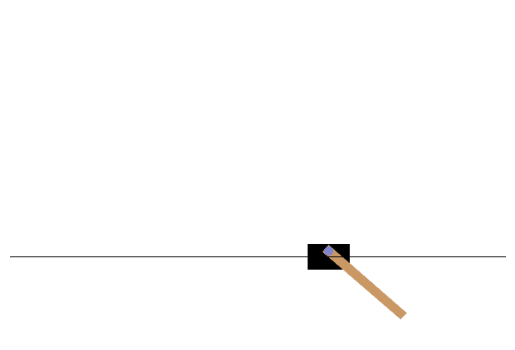

In [ ]:
env.reset()

for step in range(50):
    environment = env.render()
    show_environment(environment)
    action = env.action_space.sample()
    state, reward, term, trunc, info = env.step(action)
    clear_output(wait=True)

In [ ]:
num_state = env.observation_space.shape[0]
num_action = env.action_space.n

num_state, num_action

(4, 2)

In [ ]:
EPOCHS = 200
EPSILON_REDUCE = 0.995
LEARNING_RATE = 0.001
GAMMA = 0.95
BATCH_SIZE = 32

epsilon = 1.0

In [ ]:
import os

from keras.models import load_model, clone_model

def load_best_model():
  all_models = sorted(os.listdir(os.path.dirname(model_path)), key=lambda x: int(x.replace("cart_pole_", "")[:-3]))
  display(all_models)

  best_model_path = all_models[-1]
  best_model_path = os.path.join(os.path.dirname(model_path), "", best_model_path)
  display(best_model_path)

  print("Loading the best model:", best_model_path)
  return load_model(best_model_path)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(16, input_shape=(1, num_state)))
model.add(Activation("relu"))
model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dense(num_action))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer=Adam(learning_rate=LEARNING_RATE))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 16)             80        
                                                                 
 activation (Activation)     (None, 1, 16)             0         
                                                                 
 dense_1 (Dense)             (None, 1, 32)             544       
                                                                 
 activation_1 (Activation)   (None, 1, 32)             0         
                                                                 
 dense_2 (Dense)             (None, 1, 2)              66        
                                                                 
 activation_2 (Activation)   (None, 1, 2)              0         
                                                                 
Total params: 690 (2.70 KB)
Trainable params: 690 (2.70 

In [ ]:
# In case you want to load the best model
# model = load_best_model()

In [ ]:
target_model = clone_model(model)

## The deque data-structure is a circular buffer with maxlen set

In [ ]:
deque_1 = deque(maxlen=5)
deque_1

deque([])

In [ ]:
for i in range(5):
    deque_1.append(i)
deque_1

deque([0, 1, 2, 3, 4])

In [ ]:
deque_1.append(5)
deque_1

deque([1, 2, 3, 4, 5])

In [ ]:
deque_2 = deque(maxlen=5)
for i in range(10):
    deque_2.append(i)
    print(deque_2)

deque([0], maxlen=5)
deque([0, 1], maxlen=5)
deque([0, 1, 2], maxlen=5)
deque([0, 1, 2, 3], maxlen=5)
deque([0, 1, 2, 3, 4], maxlen=5)
deque([1, 2, 3, 4, 5], maxlen=5)
deque([2, 3, 4, 5, 6], maxlen=5)
deque([3, 4, 5, 6, 7], maxlen=5)
deque([4, 5, 6, 7, 8], maxlen=5)
deque([5, 6, 7, 8, 9], maxlen=5)


## Test of traversing each index of the list, but for all lists

In [ ]:
test_tuple = [(1, 2, 3), (4, 5, 6), (7, 8, 9)]
zipped_list = list(zip(*test_tuple))
print(test_tuple, "<>", zipped_list)

[(1, 2, 3), (4, 5, 6), (7, 8, 9)] <> [(1, 4, 7), (2, 5, 8), (3, 6, 9)]


## In the way below, we can work with vectorization

In [ ]:
list(map(np.array, zip(*test_tuple)))

[array([1, 4, 7]), array([2, 5, 8]), array([3, 6, 9])]

In [ ]:
def replay(replay_buffer, batch_size, model, target_model):
    if len(replay_buffer) < batch_size:
        return

    samples = random.sample(replay_buffer, batch_size)
    target_batch = []
    zipped_samples = list(zip(*samples))

    states, actions, rewards, next_states, dones = zipped_samples
    targets = target_model.predict(np.array(states), verbose=0)
    q_values = model.predict(np.array(next_states), verbose=0)

    for i in range(batch_size):
        q_value = max(q_values[i][0])
        target = targets[i].copy()
        if dones[i]:
            target[0][actions[i]] = rewards[i]
        else:
            target[0][actions[i]] = rewards[i] + q_value * GAMMA
        target_batch.append(target)

    model.fit(np.array(states), np.array(target_batch), epochs=1, verbose=0)

In [ ]:
def epsilon_greedy_action_selection(env, model, epsilon, state):
    if np.random.random() < epsilon:  # Exploration
        action = env.action_space.sample()
        # or
        # action = np.random.randint(0, env.action_space.n)
    else:  # Exploitation
        # Example state: [0.4, 0.6]
        prediction = model.predict(state, verbose=0)
        action = np.argmax(prediction)

    return action

## Creation of the replay buffer (used to avoid overfitting too)

In [ ]:
replay_buffer = deque(maxlen=20_000)
update_target_model = 10

In [ ]:
def update_model_handler(epoch, update_target_model, model, target_model):
    if epoch > 0 and epoch % update_target_model == 0:
        target_model.set_weights(model.get_weights())

In [ ]:
best_so_far = 0

for epoch in range(EPOCHS):
    state, info = env.reset()
    state = state.reshape([1, num_state])
    done = False
    points = 0

    while not done:
        action = epsilon_greedy_action_selection(env, model, epsilon, state)

        next_state, reward, trunc, term, info = env.step(action)
        next_state = next_state.reshape([1, num_state])
        done = trunc or term

        replay_buffer.append((state, action, reward, next_state, done))

        state = next_state
        points += 1

        replay(replay_buffer, BATCH_SIZE, model, target_model)

    epsilon *= EPSILON_REDUCE  # EPS*0.995
    update_model_handler(epoch, update_target_model, model, target_model)

    if points > best_so_far:
        best_so_far = points
        model.save(model_path.format(best_so_far=best_so_far), overwrite=True)

    if epoch % 25 == 0:
        print(f"{epoch} - Points: {points}, Eps: {epsilon}, Best: {best_so_far}")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0 - Points: 14, Eps: 0.995, Best: 14
25 - Points: 16, Eps: 0.8778091417340573, Best: 76
50 - Points: 51, Eps: 0.7744209942832988, Best: 76
75 - Points: 117, Eps: 0.6832098777212641, Best: 137
100 - Points: 83, Eps: 0.6027415843082742, Best: 169
125 - Points: 130, Eps: 0.531750826943791, Best: 217
150 - Points: 118, Eps: 0.46912134373457726, Best: 267
175 - Points: 53, Eps: 0.41386834584198684, Best: 369


In [ ]:
model.save(model_path.format(best_so_far=f"{best_so_far}"), overwrite=True)

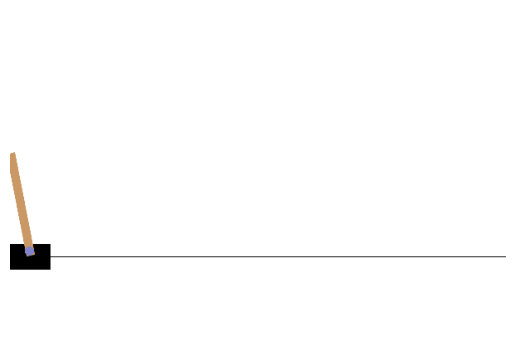

In [ ]:
best_model = load_best_model()

state, info = env.reset()

for step in range(300):
    environment = env.render()
    show_environment(environment)
    action = np.argmax(best_model.predict(state.reshape([1, 1, num_state]), verbose=0))
    state, reward, term, trunc, info = env.step(action)

    if term or trunc:
        break
    clear_output(wait=True)
env.close()